# Term2 Sprint14 授業課題 
## コーディング課題：ディープラーニングフレームワーク1 (Tensorflow)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cd gdrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**まずはロジスティック回帰を実装**

In [0]:
import numpy as np
import tensorflow as tf

計算グラフの構築

In [3]:
# データ生成
x_train = np.array([[0,0],[0,1],[1,0],[1,1]])
y_train = np.array([[0],[0],[0],[1]])

# 学習データを入力するためのplaceholderを生成
x = tf.placeholder(dtype=tf.float32, shape=[None, 2])
t = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# 重みとバイアスの変数Variableを指定(初期値0)
W = tf.Variable(tf.zeros([2,1]))
b = tf.Variable(tf.zeros([1]))

# モデル出力yと目的関数を定義
y = tf.sigmoid(tf.matmul(x, W) + b)
cross_entropy = tf.reduce_sum(-t * tf.log(y) - (1 - t) * tf.log(1 - y))

# 目的関数を勾配降下法の最適化インスタンスに渡す
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cross_entropy)

# 正解の判定と正解率も計算グラフとして定義
correct_prediction = tf.equal(tf.sign(y - 0.5), tf.sign(t - 0.5)) # 返り値はBool
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # castでBoolを0, 1に変換して平均化

Instructions for updating:
Colocations handled automatically by placer.


セッションを準備してパラメータを最適化

In [4]:
# セッションのインスタンスを生成して初期化
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 1000回学習
for epoch in range(1000):
    sess.run(train_step, feed_dict={x:x_train, t:y_train})
    
# 100回ごとに正解率を表示
    if epoch % 100 == 0:
        acc_val = sess.run(accuracy, feed_dict={x:x_train, t:y_train})
        print ('epoch: %d, Accuracy: %f' % (epoch, acc_val))


epoch: 0, Accuracy: 0.750000
epoch: 100, Accuracy: 1.000000
epoch: 200, Accuracy: 1.000000
epoch: 300, Accuracy: 1.000000
epoch: 400, Accuracy: 1.000000
epoch: 500, Accuracy: 1.000000
epoch: 600, Accuracy: 1.000000
epoch: 700, Accuracy: 1.000000
epoch: 800, Accuracy: 1.000000
epoch: 900, Accuracy: 1.000000


各サンプルの計算結果を確認

In [5]:
# 学習結果が正しいか確認
classified = sess.run(correct_prediction, feed_dict={x:x_train, t:y_train})

#出力yの確認
prob = sess.run(y, feed_dict={x:x_train, t:y_train})

print("------分類が正しければサンプルごとにTrue------\n", classified)
print("------モデル出力yの値------\n", prob)


------分類が正しければサンプルごとにTrue------
 [[ True]
 [ True]
 [ True]
 [ True]]
------モデル出力yの値------
 [[1.9648671e-04]
 [4.9049795e-02]
 [4.9049795e-02]
 [9.3120372e-01]]


学習後のWとbの値を確認

In [6]:
print('W:', sess.run(W))
print('b:', sess.run(b))

W: [[5.569954]
 [5.569954]]
b: [-8.534579]


最後にセッションを終了

In [0]:
sess.close()

## 1. スクラッチを振り返る
ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙する。

- 重みの初期化
- エポックのループ
- 各層のインスタンス化
- コスト関数値の最適化
- Forward, Backwardの実装など

**データセットの用意**  
以前から使用しているIrisデータセットを使用。

[Iris Species](https://www.kaggle.com/uciml/iris/data "Iris Species")

目的変数はSpeciesだが、3種類ある中から以下の2種類のみを取り出して使用する。

- Iris-versicolor
- Iris-virginica

## 2. スクラッチとTensorFlowの対応を考える
1.で列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認し、まとめる。

In [9]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    
    # 1エポック内でのイテレーション回数を返す
    def __len__(self):
        return self._stop
    
    # 各イテレーションで使うバッチデータを返す
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]
    
    # イテレーションのカウント数をゼロにする
    def __iter__(self):
        self._counter = 0
        return self
    
    # 次のイテレーションで使うバッチデータを返す
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder(dtype="float", shape=[None, n_input])
Y = tf.placeholder(dtype="float", shape=[None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(
            epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 136.5925, val_loss : 64.4405, acc : 0.250, val_acc : 0.625
Epoch 1, loss : 21.2192, val_loss : 42.7912, acc : 0.750, val_acc : 0.375
Epoch 2, loss : 13.8468, val_loss : 13.4117, acc : 0.500, val_acc : 0.625
Epoch 3, loss : 5.2373, val_loss : 8.9091, acc : 0.750, val_acc : 0.562
Epoch 4, loss : 0.0439, val_loss : 3.1901, acc : 1.000, val_acc : 0.875
Epoch 5, loss : 0.0008, val_loss : 2.3204, acc : 1.000, val_acc : 0.750
Epoch 6, loss : 0.0000, val_loss : 0.4958, acc : 1.000, val_acc : 0.938
Epoch 7, loss : 0.0000, val_loss : 0.0001, acc : 1.000, val_acc : 1.000
Epoch 8, loss : 0.0000, val_loss : 0.0001, acc : 1.000, val_acc : 1.000
Epoch 9, loss : 0.0000, val_loss : 0.0000, acc : 1.000, val_acc : 1.000
test_acc : 0.900


Tensorflowでは以下のように実装されている。

- 重みの初期化: tf.global_variables_initializer()
- エポックのループ: tf.Session()の中で実行
- 各層のインスタンス化: tf.Variable()で定義した変数にてtf.matmul, tf.add, tf.nn.reluを用いて層を形成
- Forward, Backwardの実装: tf.train.AdamOptimizer
- コスト関数値の最適化: tf.train.AdamOptimizer.minimizeで最適化手法により最小化していく

## 3. 3種類全ての目的変数を使用したIrisのモデルを作成
[Iris Species](https://www.kaggle.com/uciml/iris/data "Iris Species")

上記リンク先のiris.csvを使用する。  
目的変数はSpeciesに含まれる3種類全てを使う。

2クラスの分類と3クラス以上の分類の違いを考慮する。

それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べる。

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = df["Species"]
X = np.array(X)
y = np.array(y)
# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

# yをOneHotEncoding
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(y)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, n_classes)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    
    # 1エポック内でのイテレーション回数を返す
    def __len__(self):
        return self._stop
    
    # 各イテレーションで使うバッチデータを返す
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]
    
    # イテレーションのカウント数をゼロにする
    def __iter__(self):
        self._counter = 0
        return self
    
    # 次のイテレーションで使うバッチデータを返す
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3

# 計算グラフに渡す引数の形を決める
X = tf.placeholder(dtype=tf.float32, shape=[None, n_input])
Y = tf.placeholder(dtype=tf.int32, shape=[None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数(3値分類)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))
# correct_pred = tf.argmax(tf.nn.softmax(logits), axis=1)
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(
            epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 41.7363, val_loss : 99.4315, acc : 0.667, val_acc : 0.292
Epoch 1, loss : 58.3206, val_loss : 29.9967, acc : 0.333, val_acc : 0.708
Epoch 2, loss : 7.2275, val_loss : 8.4700, acc : 0.333, val_acc : 0.708
Epoch 3, loss : 0.0000, val_loss : 1.2194, acc : 1.000, val_acc : 0.917
Epoch 4, loss : 0.0000, val_loss : 1.0825, acc : 1.000, val_acc : 0.792
Epoch 5, loss : 1.1150, val_loss : 6.7111, acc : 0.833, val_acc : 0.667
Epoch 6, loss : 3.0603, val_loss : 12.6693, acc : 0.833, val_acc : 0.625
Epoch 7, loss : 0.0001, val_loss : 4.4025, acc : 1.000, val_acc : 0.708
Epoch 8, loss : 0.0000, val_loss : 2.1470, acc : 1.000, val_acc : 0.917
Epoch 9, loss : 0.0000, val_loss : 3.0222, acc : 1.000, val_acc : 0.917
test_acc : 0.833


## 4. House Pricesのモデルを作成
回帰問題のデータセットであるHouse Pricesを使用したモデルを作成する。

[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data "House Prices: Advanced Regression Techniques")

この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使う。  
説明変数はさらに増やしても構わない。

分類問題と回帰問題の違いを考慮する。

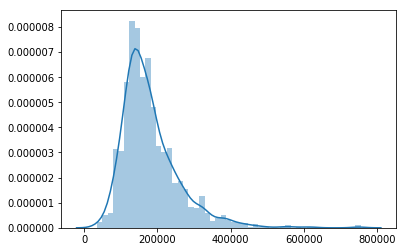

目的変数の尖度 6.536281860064529
目的変数の歪度 1.8828757597682129


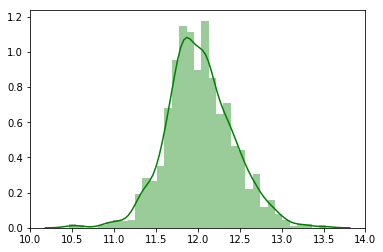

目的変数（logスケール）の尖度 0.8095319958036296
目的変数（logスケール）の歪度 0.12133506220520406


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# データセットの読み込み
df = pd.read_csv("train.csv")
# データフレームから条件抽出
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = df["SalePrice"]
X = np.array(X).astype(np.float64)
y = np.array(y).astype(np.float64)

# 目的変数の分布、尖度、歪度
sns.distplot(y)
plt.show()
print("目的変数の尖度", pd.Series(y).kurt())
print("目的変数の歪度", pd.Series(y).skew())

# 目的変数を対数変換
y = np.log(y)

# 目的変数（logスケール）の分布、尖度、歪度
sns.distplot(y, color="g")
plt.show()
print("目的変数（logスケール）の尖度", pd.Series(y).kurt())
print("目的変数（logスケール）の歪度", pd.Series(y).skew())

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 標準化
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
y_test = sc_y.transform(y_test[:, np.newaxis]).flatten()

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


In [0]:
class Tf_nn:
    """
    Tensorflowを使った単純なニューラルネットワーク(House prices用)
    
    """
    def __init__(self, n_features, n_hidden1, n_hidden2, learning_rate=0.01, random_seed=None):
        self.n_features = n_features
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        
        # 計算グラフを構築
        with self.g.as_default():
            # 計算グラフ内の乱数シードを設定
            tf.set_random_seed(random_seed)
            
            # 入力値のplaceholderを作成
            self.X = tf.placeholder(
                dtype=tf.float32, shape=(None, self.n_features), name='x_input')
            self.y = tf.placeholder(
                dtype=tf.float32, shape=(None), name='y_input')
            
            # 重みとバイアスの宣言
            weights = {
                'w1': tf.Variable(tf.random_normal([n_features, n_hidden1])),
                'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
                'w3': tf.Variable(tf.random_normal([n_hidden2, 1]))
            }
            biases = {
                'b1': tf.Variable(tf.random_normal([n_hidden1])),
                'b2': tf.Variable(tf.random_normal([n_hidden2])),
                'b3': tf.Variable(tf.random_normal([1]))
            }
            
            layer_1 = tf.add(tf.matmul(self.X, weights['w1']), biases['b1'])
            layer_1 = tf.nn.relu(layer_1)
            layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
            layer_2 = tf.nn.relu(layer_2)
            self.prediction = tf.matmul(layer_2, weights['w3']) + biases['b3']
            
            # 最小２乗誤差を定義
            sqr_errors = tf.square(self.y - self.prediction, name='sqr_errors')
            self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')
            
            # 最適化手法を定義
            optimizer = tf.train.AdamOptimizer(
                learning_rate=self.learning_rate, name='AdamOptimizer')
            self.train_op = optimizer.minimize(loss=self.mean_cost)
            
            # 最適化手法のInitializerを生成
            self.init_op = tf.global_variables_initializer()
    

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, n_classes)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    
    # 1エポック内でのイテレーション回数を返す
    def __len__(self):
        return self._stop
    
    # 各イテレーションで使うバッチデータを返す
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]
    
    # イテレーションのカウント数をゼロにする
    def __iter__(self):
        self._counter = 0
        return self
    
    # 次のイテレーションで使うバッチデータを返す
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


def train_func(sess, model, X_train, y_train, 
               X_val=None, y_val=None, num_epochs=10, batch_size=10):
    """
    Tensorflowを使ったモデルで学習するための関数
    
    """
    # パラメータ係数の初期化
    sess.run(model.init_op)
    # コスト関数値を格納する空リストを作成
    train_costs = []
    val_costs = []
    
    # trainのミニバッチイテレータ
    get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
    # エポック回数で学習
    for i in range(num_epochs):
        # バッチデータ毎に学習
        total_cost = 0.
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 訓練データで学習
            _, batch_cost = sess.run([model.train_op, model.mean_cost], 
                               feed_dict={model.X:mini_batch_x, model.y:mini_batch_y})
            total_cost += batch_cost
        # 訓練データのコスト関数値を格納
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        train_costs.append(total_cost / total_batch)
        # 検証データがあれば、そのコスト関数値も格納
        if X_val is not None and y_val is not None:
            val_cost = sess.run(model.mean_cost, 
                                feed_dict={model.X:X_val, model.y:y_val})
            val_costs.append(val_cost)    
    
    return train_costs, val_costs


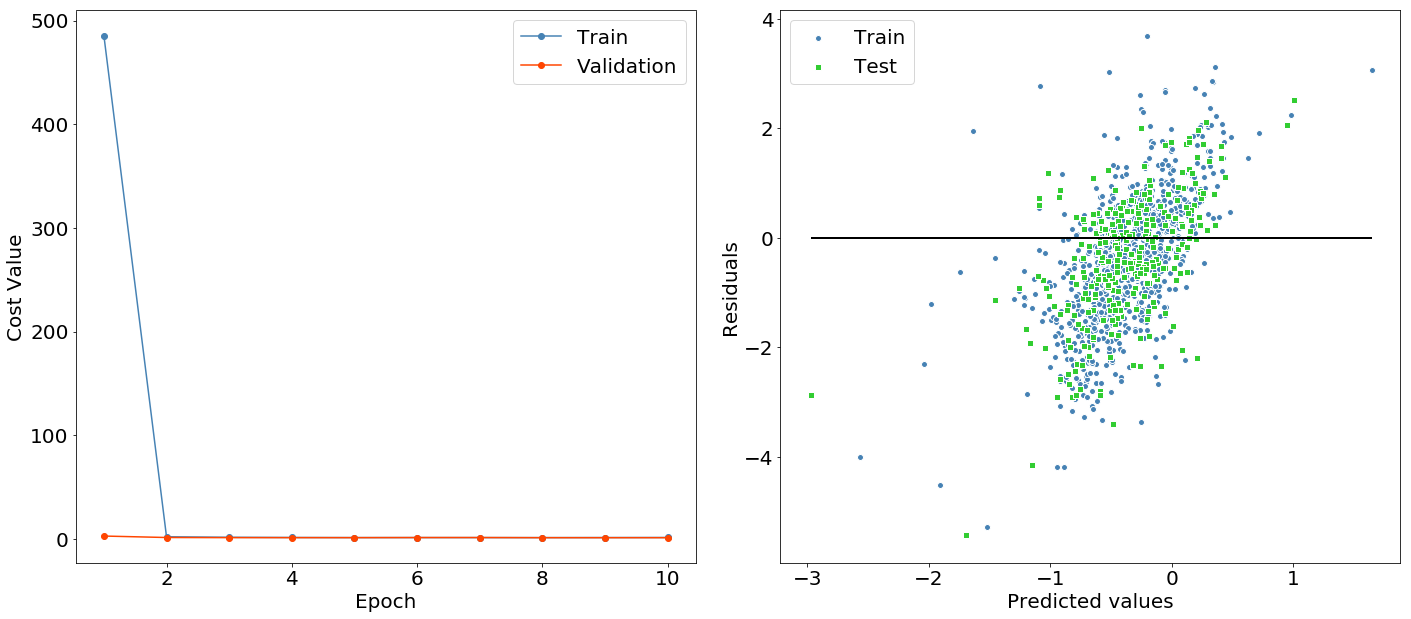

In [18]:
# 必要な値を用意
n_hidden1 = 50
n_hidden2 = 100
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
learning_rate = 0.1
random_seed = 123

# モデルのインスタンスを生成
nnmodel = Tf_nn(n_features, n_hidden1, n_hidden2, learning_rate, random_seed)

# セッション開始
with tf.Session(graph=nnmodel.g) as sess:
    # 訓練データで学習(検証データもあれば引数として渡す)
    train_costs, val_costs = train_func(
        sess, nnmodel, X_train, y_train, X_val, y_val, num_epochs=10, batch_size=10)
    # train_costs, _ = train_func(sess, nnmodel, X_train, y_train, num_epochs=100)
    
    # 訓練データとテストデータで予測
    y_train_pred = sess.run(
        nnmodel.prediction, feed_dict={nnmodel.X:X_train}).flatten()
    y_test_pred = sess.run(
        nnmodel.prediction, feed_dict={nnmodel.X:X_test}).flatten()
    
    # 学習曲線と残差プロットを可視化
    plt.rcParams["font.size"] = 20
    fig, ax = plt.subplots(1,2,figsize=(20,9))
    # 学習曲線
    plt.subplot(1,2,1)
    plt.plot(range(1,len(train_costs) + 1), train_costs, 
             marker="o", color="steelblue", label="Train")
    plt.plot(range(1,len(val_costs) + 1), val_costs, 
             marker="o", color="orangered", label="Validation")
    plt.xlabel('Epoch')
    plt.ylabel('Cost Value')
    plt.legend(loc="best")
    plt.tight_layout()
    # 残差プロット
    plt.subplot(1,2,2)
    plt.scatter(y_train_pred,  y_train_pred - y_train, 
                c='steelblue', marker='o', edgecolor='white', label='Train')
    plt.scatter(y_test_pred,  y_test_pred - y_test,
                c='limegreen', marker='s', edgecolor='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    train_max = max(y_train_pred)
    train_min = min(y_train_pred)
    test_max = max(y_test_pred)
    test_min = min(y_test_pred)
    plt.hlines(y=0, xmin=min(train_min, test_min), 
               xmax=max(train_max, test_max), color='black', lw=2)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


特徴量を4つに増やして同様に実行してみる。

In [0]:
# データフレームから条件抽出
X = df.loc[:, ["GrLivArea", "YearBuilt", "OverallQual", "GarageArea"]]
y = df["SalePrice"]
X = np.array(X).astype(np.float64)
y = np.array(y).astype(np.float64)

# 目的変数を対数変換
y = np.log(y)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 標準化
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
y_test = sc_y.transform(y_test[:, np.newaxis]).flatten()

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


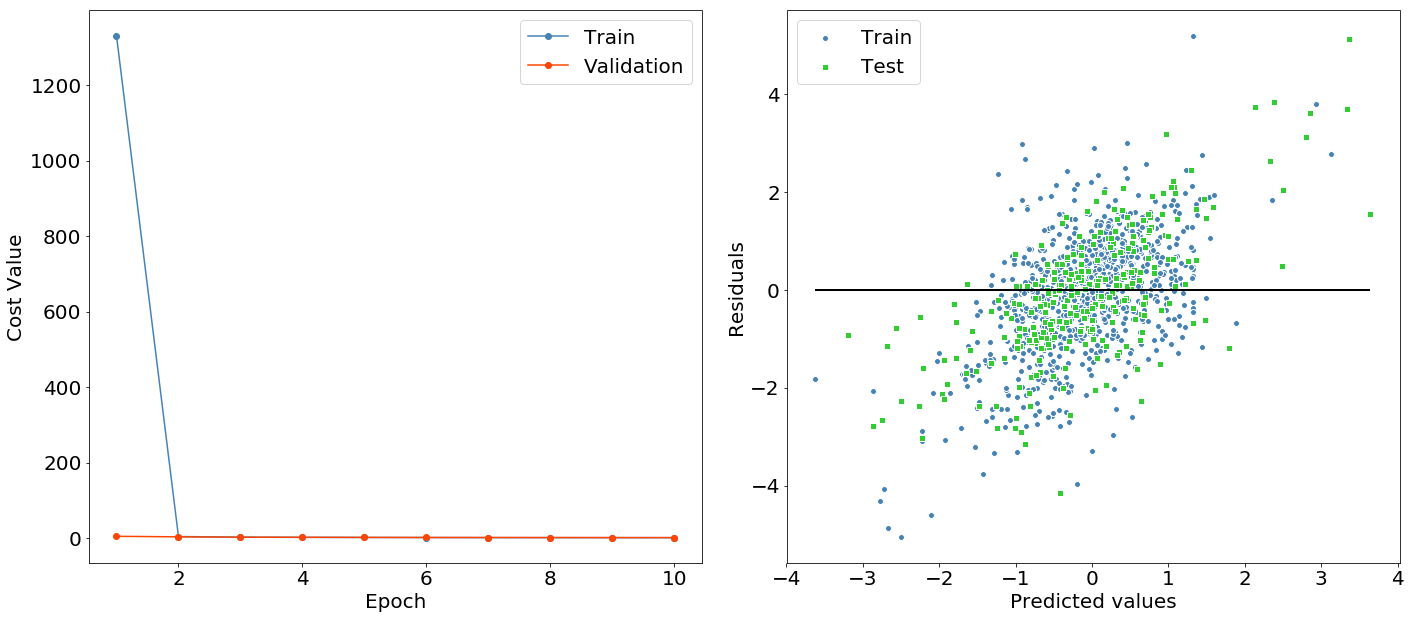

In [20]:
# 必要な値を用意
n_hidden1 = 50
n_hidden2 = 100
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
learning_rate = 0.1
random_seed = 123

# モデルのインスタンスを生成
nnmodel = Tf_nn(n_features, n_hidden1, n_hidden2, learning_rate, random_seed)

# セッション開始
with tf.Session(graph=nnmodel.g) as sess:
    # 訓練データで学習(検証データもあれば引数として渡す)
    train_costs, val_costs = train_func(
        sess, nnmodel, X_train, y_train, X_val, y_val, num_epochs=10, batch_size=10)
    # train_costs, _ = train_func(sess, nnmodel, X_train, y_train, num_epochs=100)
    
    # 訓練データとテストデータで予測
    y_train_pred = sess.run(
        nnmodel.prediction, feed_dict={nnmodel.X:X_train}).flatten()
    y_test_pred = sess.run(
        nnmodel.prediction, feed_dict={nnmodel.X:X_test}).flatten()
    
    # 学習曲線と残差プロットを可視化
    plt.rcParams["font.size"] = 20
    fig, ax = plt.subplots(1,2,figsize=(20,9))
    # 学習曲線
    plt.subplot(1,2,1)
    plt.plot(range(1,len(train_costs) + 1), train_costs, 
             marker="o", color="steelblue", label="Train")
    plt.plot(range(1,len(val_costs) + 1), val_costs, 
             marker="o", color="orangered", label="Validation")
    plt.xlabel('Epoch')
    plt.ylabel('Cost Value')
    plt.legend(loc="best")
    plt.tight_layout()
    # 残差プロット
    plt.subplot(1,2,2)
    plt.scatter(y_train_pred,  y_train_pred - y_train, 
                c='steelblue', marker='o', edgecolor='white', label='Train')
    plt.scatter(y_test_pred,  y_test_pred - y_test,
                c='limegreen', marker='s', edgecolor='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    train_max = max(y_train_pred)
    train_min = min(y_train_pred)
    test_max = max(y_test_pred)
    test_min = min(y_test_pred)
    plt.hlines(y=0, xmin=min(train_min, test_min), 
               xmax=max(train_max, test_max), color='black', lw=2)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


## 5. MNISTのモデルを作成
ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成する。

3クラス以上の分類という点ではひとつ前のIrisと同様。  
入力が画像であるという点で異なる。

スクラッチで実装したモデルの再現を目指す。

In [47]:
!pip install pyprind
import pyprind
from keras.datasets import mnist

# データ生成
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# (n_samples, n_channels, height, width)のNCHWに次元整形
# 今回はモノクロなのでチャンネル数は1(サンプル数, 高さ, 幅, チャンネル数)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 訓練データから更に検証データを生成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print("X_train.shape: ", X_train.shape)
print("X_val.shape: ", X_val.shape)
print("y_train.shape: ", y_train.shape)
print("y_val.shape: ", y_val.shape)

X_train.shape:  (48000, 28, 28, 1)
X_val.shape:  (12000, 28, 28, 1)
y_train.shape:  (48000,)
y_val.shape:  (12000,)


In [0]:
class Tf_cnn:
    """
    Tensorflowを使ったニューラルネットワーク(MNIST用)
    
    """
    def __init__(self, learning_rate=0.01, random_seed=None):
        self.g = tf.Graph()
        
        # 計算グラフを構築
        with self.g.as_default():
            # 計算グラフ内の乱数シードを設定
            tf.set_random_seed(random_seed)
            
            self.X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='X_input')
            self.y = tf.placeholder(tf.int32, shape=[None], name='y_input')

            # One-hot encoding:
            y_onehot = tf.one_hot(
                indices=self.y, depth=10, dtype=tf.float32, name='tf_y_onehot')

            # 畳み込み層、プーリング層の2セットを定義
            h1 = self._conv_layer(self.X, name='conv_1', 
                             kernel_size=(5, 5), padding_mode='VALID', n_output_channels=32)
            h1_pool = tf.nn.max_pool(
                h1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            h2 = self._conv_layer(h1_pool, name='conv_2', 
                             kernel_size=(5, 5), padding_mode='VALID', n_output_channels=64)
            h2_pool = tf.nn.max_pool(
                h2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            
            # 全結合層を定義
            h3 = self._fullconn_layer(
                h2_pool, name='fc_3', n_output_units=1024, activation_func=tf.nn.relu)

            # ドロップアウト層を定義
            self.keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
            h3_drop = tf.nn.dropout(h3, keep_prob=self.keep_prob, name='dropout_layer')
            
            # 出力層を定義
            h4 = self._fullconn_layer(
                h3_drop, name='fc_4', n_output_units=10, activation_func=None)

            # 予測
            self.predictions = {
                'probabilities' : tf.nn.softmax(h4, name='probabilities'),
                'labels' : tf.cast(tf.argmax(h4, axis=1), tf.int32, name='labels')
            }

            # 損失関数
            self.cross_entropy_loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits_v2(
                    logits=h4, labels=y_onehot), name='cross_entropy_loss')
            
            # 最適化手法を定義
            optimizer = tf.train.AdamOptimizer(learning_rate)
            self.train_op = optimizer.minimize(self.cross_entropy_loss, name='train_op')

            # 正解率を定義
            correct_predictions = tf.equal(
                self.predictions['labels'], self.y, name='correct_preds')
            self.accuracy = tf.reduce_mean(
                tf.cast(correct_predictions, tf.float32), name='accuracy')
            
            # 全変数のInitializerを生成
            self.init_op = tf.global_variables_initializer()
    
    def _conv_layer(self, input_tensor, name, kernel_size, 
                    n_output_channels, padding_mode='SAME', strides=(1, 1, 1, 1)):
      """
      畳み込み層構築用のラッパー関数
      
      input_tensor: 入力テンソル(バッチ数, 高さ, 幅, 入力チャンネル数)
      name: 層の名前(スコープ名)
      kernel_size: フィルターを構成するカーネルのサイズ(高さと幅のリストまたはタプル)
      n_output_channels: 出力チャンネル数
      padding_mode: パディングの種類(default: 入力ベクトルと同じにする"SAME")
      strides: ストライド数のタプル(default: (1,1,1,1))
      
      """
      # 変数管理用のスコープ定義
      with tf.variable_scope(name):
        
        # 入力チャンネル数を取得
        input_shape = input_tensor.get_shape().as_list()
        n_input_channels = input_shape[-1]
        # 重みwとバイアスbを定義
        weights_shape = (list(kernel_size) + [n_input_channels, n_output_channels])
        weights = tf.get_variable(name='_weights', shape=weights_shape)
        biases = tf.get_variable(name='_biases', 
                                 initializer=tf.zeros(shape=[n_output_channels]))

        # 入力テンソルとフィルターで畳み込み
        conv = tf.nn.conv2d(
            input=input_tensor, filter=weights, strides=strides, padding=padding_mode)
        # バイアスbを加算
        conv = tf.nn.bias_add(conv, biases, name='net_pre-activation')
        # ReLUで活性化
        conv = tf.nn.relu(conv, name='activation')

        return conv
    
    def _fullconn_layer(self, input_tensor, name, n_output_units, activation_func=None):
      """
      全結合層構築用のラッパー関数
      
      input: 入力テンソル(バッチ数, 高さ, 幅, 入力チャンネル数)
      name: 層の名前(スコープ名)
      n_output_units: 出力ユニット数
      activation_func: 活性化関数(default: None)
      
      """
      # 変数管理用のスコープ定義
      with tf.variable_scope(name):
        
        # 1サンプルあたりの要素の総数を計算(配列要素の積)
        input_shape = input_tensor.get_shape().as_list()[1:]
        n_input_units = np.prod(input_shape)
        # 畳み込み層からの入力の場合は平滑化する
        if len(input_shape) > 1:
          input_tensor = tf.reshape(input_tensor, shape=(-1, n_input_units))
        
        # 重みwとバイアスbを定義
        weights_shape = [n_input_units, n_output_units]
        weights = tf.get_variable(name='_weights', shape=weights_shape)
        biases = tf.get_variable(
            name='_biases', initializer=tf.zeros(shape=[n_output_units]))
        
        # 入力テンソルと重みとの内積
        layer = tf.matmul(input_tensor, weights)
        # バイアスbを加算
        layer = tf.nn.bias_add(layer, biases, name='net_pre-activation')
        
        # 出力層の場合は活性化しない
        if activation_func is None:
          return layer
        
        # 隠れ層の場合は活性化
        layer = activation_func(layer, name='activation')
        return layer
    

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, n_classes)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    
    # 1エポック内でのイテレーション回数を返す
    def __len__(self):
        return self._stop
    
    # 各イテレーションで使うバッチデータを返す
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]
    
    # イテレーションのカウント数をゼロにする
    def __iter__(self):
        self._counter = 0
        return self
    
    # 次のイテレーションで使うバッチデータを返す
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


def train_func(sess, model, X_train, y_train, 
               X_val=None, y_val=None, num_epochs=10, batch_size=10, dropout=0.5):
    """
    Tensorflowを使ったモデルで学習するための関数
    
    """
    # パラメータ係数の初期化
    sess.run(model.init_op)
    # コスト関数値を格納する空リストを作成
    train_costs = []
    val_costs = []
    
    # trainのミニバッチイテレータを生成
    get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
    
    # 学習の進捗バーを設定
    pbar = pyprind.ProgBar(
        num_epochs * (np.ceil(X_train.shape[0] / batch_size).astype(np.int)))
    
    # エポック回数で学習
    for i in range(num_epochs):
        # バッチデータ毎に学習
        total_cost = 0.
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 訓練データで学習
            feed = {model.X:mini_batch_x, model.y:mini_batch_y, model.keep_prob:dropout}
            _, batch_cost = sess.run(
                [model.train_op, model.cross_entropy_loss], feed_dict=feed)
            total_cost += batch_cost
            # 進捗バーを更新
            pbar.update()
        # 訓練データのコスト関数値を格納
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        train_costs.append(total_cost / total_batch)
        # 検証データがあれば、そのコスト関数値も格納
        if X_val is not None and y_val is not None:
          feed = {model.X:X_val, model.y:y_val, model.keep_prob:1.0}
          val_cost = sess.run(model.cross_entropy_loss, feed_dict=feed)
          val_costs.append(val_cost)    
    
    return train_costs, val_costs


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:52


Train accuracy: 0.9987
Test accuracy: 0.9921


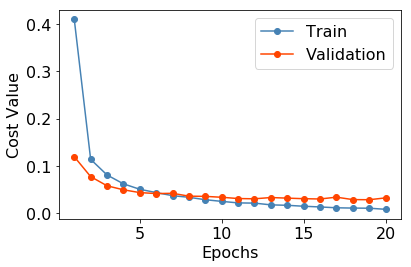

In [49]:
# 必要な値を用意
learning_rate = 0.0001
random_seed = 123

# モデルのインスタンスを生成
cnn_model = Tf_cnn(learning_rate, random_seed)

# セッション開始
with tf.Session(graph=cnn_model.g) as sess:
    # 訓練データで学習(検証データもあれば引数として渡す)
    train_costs, val_costs = train_func(
        sess, cnn_model, X_train, y_train, X_val, y_val, 
        num_epochs=20, batch_size=50, dropout=0.5)
    # train_costs, _ = train_func(sess, nnmodel, X_train, y_train, num_epochs=100)
    
    # 正解率を算出
    train_accuracy = sess.run(
        cnn_model.accuracy, 
        feed_dict={cnn_model.X:X_train, cnn_model.y:y_train, cnn_model.keep_prob:1.0})
    test_accuracy = sess.run(
        cnn_model.accuracy, 
        feed_dict={cnn_model.X:X_test, cnn_model.y:y_test, cnn_model.keep_prob:1.0})
    print("Train accuracy: {:.4f}".format(train_accuracy))
    print("Test accuracy: {:.4f}".format(test_accuracy))
    
    # 学習曲線を可視化
    plt.rcParams["font.size"] = 16
    plt.plot(range(1,len(train_costs) + 1), train_costs, 
             marker="o", color="steelblue", label="Train")
    plt.plot(range(1,len(val_costs) + 1), val_costs, 
             marker="o", color="orangered", label="Validation")
    plt.xlabel('Epochs')
    plt.ylabel('Cost Value')
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
